**Modification:**
- No shared layer
- Apply cnn

In [1]:
import os
import argparse
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from keras.models import Sequential, Model
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras.layers import Input, Reshape, Flatten, merge
from keras import optimizers, regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, History
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv1D, MaxPooling1D

Using Theano backend.


In [3]:
name = 'helpdesk'
args = {
    'inputdir': '../input/{}/'.format(name),   
    'outputdir': './output_files/{0}/'.format(name)
}

args = argparse.Namespace(**args)

In [4]:
if not os.path.isdir(args.outputdir):
    os.makedirs(args.outputdir)

In [5]:
with open(args.inputdir + 'parameters.pkl', "rb") as f:
    maxlen = pickle.load(f)
    num_features = pickle.load(f)
    chartoindice = pickle.load(f)
    targetchartoindice = pickle.load(f)
    divisor = pickle.load(f)
    divisor2 = pickle.load(f)

In [6]:
with open(args.inputdir + 'preprocessed_data.pkl', "rb") as f:
    X = pickle.load(f)
    y_a = pickle.load(f)
    y_t = pickle.load(f)
    X_test = pickle.load(f)
    y_a_test = pickle.load(f)
    y_t_test = pickle.load(f)

# Model 1

In [8]:
# build the model: 
print('Build model lstm with cnn...')
main_input = Input(shape=(maxlen, num_features), name='main_input')


l1 = LSTM(500, implementation=2, kernel_initializer="glorot_uniform", dropout=0.2, return_sequences=True)(main_input)
b1 = BatchNormalization()(l1)

l2 = LSTM(500, implementation=2, kernel_initializer="glorot_uniform", dropout=0.2, return_sequences=True)(main_input)
b2 = BatchNormalization()(l2)

# the layer specialized in activity prediction
l2_1 = LSTM(100, implementation=2, kernel_initializer="glorot_uniform", dropout=0.2, return_sequences=False)(b1) 
b2_1 = BatchNormalization()(l2_1)


# the layer specialized in time prediction
l2_2 = LSTM(100, implementation=2, kernel_initializer="glorot_uniform", dropout=0.2, return_sequences=False)(b2) 
b2_2 = BatchNormalization()(l2_2)


act_output = Dense(len(targetchartoindice), activation="softmax", kernel_initializer="glorot_uniform", name="act_output")(b2_1)
time_output = Dense(1, kernel_initializer="glorot_uniform", name="time_output")(b2_2)


model = Model(inputs=[main_input], outputs=[act_output, time_output])

#compilations
opt = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004, clipvalue=3)
model.compile(loss={'act_output':'categorical_crossentropy', 'time_output':'mean_absolute_error'}, 
              optimizer=opt, metrics=['accuracy'])

#callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=42)
model_checkpoint = ModelCheckpoint(args.outputdir + 'model_{epoch:02d}-{val_loss:.2f}.h5', 
                                   monitor='val_loss', verbose=0, save_best_only=True, 
                                   save_weights_only=False, mode='auto')
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, 
                               verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
history = History()

#fit
model.fit(X, {'act_output':y_a, 'time_output':y_t}, validation_split=0.2, verbose=2, 
          callbacks=[early_stopping, model_checkpoint, lr_reducer, history], batch_size=16, epochs=500)

Build model lstm with cnn...
Train on 7344 samples, validate on 1837 samples
Epoch 1/500
114s - loss: 2.1377 - act_output_loss: 0.9578 - time_output_loss: 1.1799 - act_output_acc: 0.7104 - time_output_acc: 0.2277 - val_loss: 1.7296 - val_act_output_loss: 0.6782 - val_time_output_loss: 1.0514 - val_act_output_acc: 0.8062 - val_time_output_acc: 0.2847
Epoch 2/500
120s - loss: 1.8564 - act_output_loss: 0.7963 - time_output_loss: 1.0601 - act_output_acc: 0.7463 - time_output_acc: 0.2764 - val_loss: 1.7466 - val_act_output_loss: 0.6042 - val_time_output_loss: 1.1424 - val_act_output_acc: 0.8220 - val_time_output_acc: 0.2869
Epoch 3/500
128s - loss: 1.7136 - act_output_loss: 0.6951 - time_output_loss: 1.0184 - act_output_acc: 0.7823 - time_output_acc: 0.2823 - val_loss: 1.6564 - val_act_output_loss: 0.6485 - val_time_output_loss: 1.0079 - val_act_output_acc: 0.8089 - val_time_output_acc: 0.2869
Epoch 4/500
126s - loss: 1.6823 - act_output_loss: 0.6665 - time_output_loss: 1.0158 - act_output_

# Model cnn

In [ ]:
# build the model: 
print('Build model lstm with cnn...')
main_input = Input(shape=(maxlen, num_features), name='main_input')

con = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(main_input)
pool = MaxPooling1D(pool_size=2)(con)

# one shared layer
l1 = LSTM(100, implementation=2, kernel_initializer="glorot_uniform", dropout=0.2, return_sequences=True)(con)
b1 = BatchNormalization()(l1)

# the layer specialized in activity prediction
l2_1 = LSTM(100, implementation=2, kernel_initializer="glorot_uniform", dropout=0.2, return_sequences=False)(b1) 
b2_1 = BatchNormalization()(l2_1)


# the layer specialized in time prediction
l2_2 = LSTM(100, implementation=2, kernel_initializer="glorot_uniform", dropout=0.2, return_sequences=False)(b1) 
b2_2 = BatchNormalization()(l2_2)


act_output = Dense(len(targetchartoindice), activation="softmax", kernel_initializer="glorot_uniform", name="act_output")(b2_1)
time_output = Dense(1, kernel_initializer="glorot_uniform", name="time_output")(b2_2)


model = Model(inputs=[main_input], outputs=[act_output, time_output])

#compilations
opt = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004, clipvalue=3)
model.compile(loss={'act_output':'categorical_crossentropy', 'time_output':'mean_absolute_error'}, 
              optimizer=opt, metrics=['accuracy'])

#callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=83)
model_checkpoint = ModelCheckpoint(args.outputdir + 'model_{epoch:02d}-{val_loss:.2f}.h5', 
                                   monitor='val_loss', verbose=0, save_best_only=True, 
                                   save_weights_only=False, mode='auto')
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, 
                               verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
history = History()

#fit
model.fit(X, {'act_output':y_a, 'time_output':y_t}, validation_split=0.2, verbose=2, 
          callbacks=[early_stopping, model_checkpoint, lr_reducer, history], batch_size=16, epochs=500)

In [ ]:
model.summary()

In [ ]:
history.history.keys()

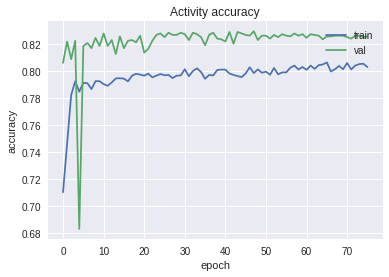

In [9]:
# summarize history for activity accuracy
plt.plot(history.history['act_output_acc'])
plt.plot(history.history['val_act_output_acc'])
plt.title('Activity accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

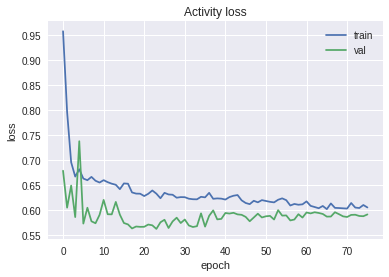

In [10]:
# summarize history for activity loss
plt.plot(history.history['act_output_loss'])
plt.plot(history.history['val_act_output_loss'])
plt.title('Activity loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

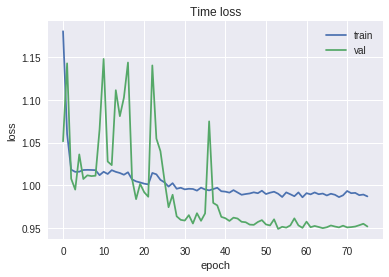

In [11]:
# summarize history for time loss
plt.plot(history.history['time_output_loss'])
plt.plot(history.history['val_time_output_loss'])
plt.title('Time loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

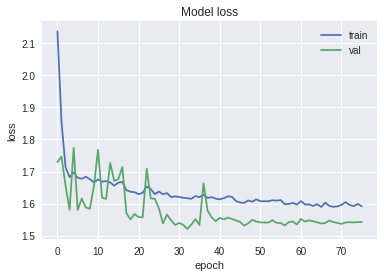

In [12]:
# summarize history for model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()